In [38]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, random_split

from abs_cam import AbsCAMInit, AbsCAMFinal
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms.functional as F

from utils import *
from evaluation import CausalMetric, auc, gkern

import zipfile

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# --- SET SEED FOR REPRODUCIBILITY ---
SEED = 42  # фиксируем seed для полной воспроизводимости
torch.manual_seed(SEED)  # фиксируем seed для PyTorch
random.seed(SEED)        # фиксируем seed для Python random
np.random.seed(SEED)     # фиксируем seed для NumPy
torch.backends.cudnn.deterministic = True  # гарантирует детерминированность на GPU
torch.backends.cudnn.benchmark = False     # отключаем autotuner, чтобы не влиял на детерминированность

# --- CONFIGURATION ---
output = 'data_full.zip'
unzip_dir = 'unzipped_data_full'

if not os.path.exists(unzip_dir):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(unzip_dir)

data_dir = 'unzipped_data_full/data_full'
batch_size = 8                 # количество изображений в одном батче
num_epochs = 20                # сколько раз модель проходит весь датасет
val_split = 0.2                # доля валидационных данных (20%)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # автоматический выбор CUDA или CPU
device

device(type='cuda')

In [40]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

In [41]:
# трансформации для валидационной выборки (без аугментаций)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# --- DATASET ---
full_dataset = datasets.ImageFolder(data_dir)   # читаем датасет: каждая папка = один класс
class_names = full_dataset.classes              # сохраняем список классов

val_size = int(len(full_dataset) * val_split)   # размер валидационной выборки
train_size = len(full_dataset) - val_size       # размер тренировочной выборки

# фиксированный random_split с генератором (для стабильного train/val деления)
generator = torch.Generator().manual_seed(SEED)
_, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

# применяем трансформации
val_dataset.dataset.transform = val_transform

In [42]:
model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(class_names))

model.load_state_dict(torch.load('best_model.pth'))
# model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()
model = model.to(device)

In [43]:
explainer_init = AbsCAMInit(model, target_layer='layer4', device=device)
explainer_final = AbsCAMFinal(model, target_layer='layer4', device=device)

saliency_init: 0.0 1.0 0.433279812335968
saliency_final: 0.0 0.7475774884223938 0.32391029596328735


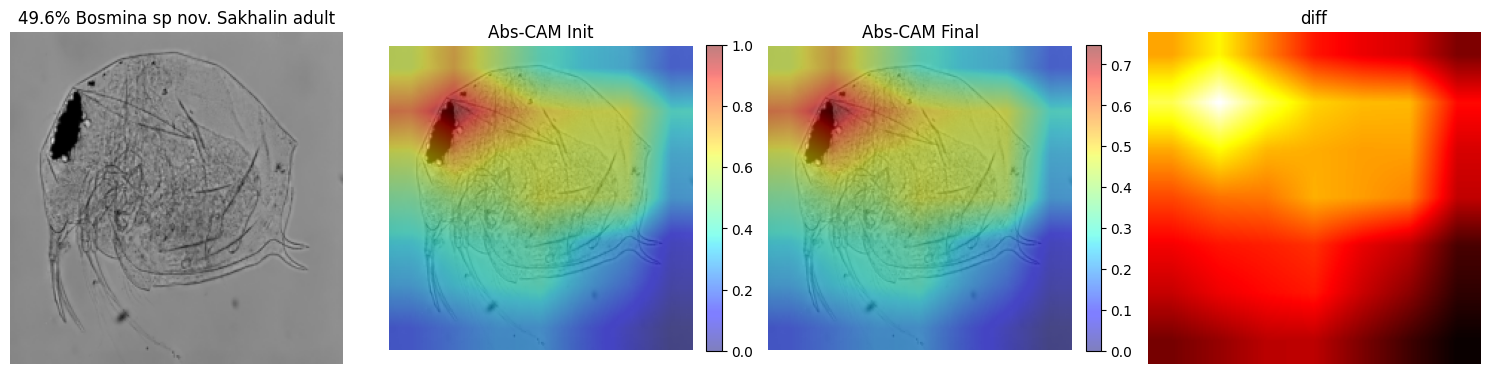

In [44]:
def explain_and_plot(img, label=None, class_names=None):
    saliency_init = explainer_init(img).astype(np.float32)
    saliency_final = explainer_final(img).astype(np.float32)

    print("saliency_init:", saliency_init.min().item(), saliency_init.max().item(), saliency_init.mean().item())
    print("saliency_final:", saliency_final.min().item(), saliency_final.max().item(), saliency_final.mean().item())

    with torch.no_grad():
        output = model(img)
        probs = torch.softmax(output, dim=1)
        conf, class_idx = torch.max(probs, dim=1)
        class_name = class_names[class_idx.item()]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.axis('off')
    plt.title(f'{100 * conf.item():.1f}% {class_name}')
    tensor_imshow(img[0].cpu())

    # Abs-CAM Init
    plt.subplot(1, 4, 2)
    plt.axis('off')
    plt.title('Abs-CAM Init')
    tensor_imshow(img[0].cpu())
    plt.imshow(saliency_init, cmap='jet', alpha=0.5)
    plt.colorbar(fraction=0.046, pad=0.04)

    # Abs-CAM Final
    plt.subplot(1, 4, 3)
    plt.axis('off')
    plt.title('Abs-CAM Final')
    tensor_imshow(img[0].cpu())
    plt.imshow(saliency_final, cmap='jet', alpha=0.5)
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.subplot(1, 4, 4)
    plt.axis('off')
    plt.title('diff')
    diff = np.abs(saliency_final - saliency_init)
    plt.imshow(diff, cmap='hot')

    plt.tight_layout()
    plt.show()


sample_img, label = val_dataset[0]
sample_img = sample_img.unsqueeze(0).to(device) 
explain_and_plot(sample_img, label=label, class_names=class_names)

saliency_init: 0.0 1.0 0.35516366362571716
saliency_final: 0.0 0.20506085455417633 0.07283017039299011


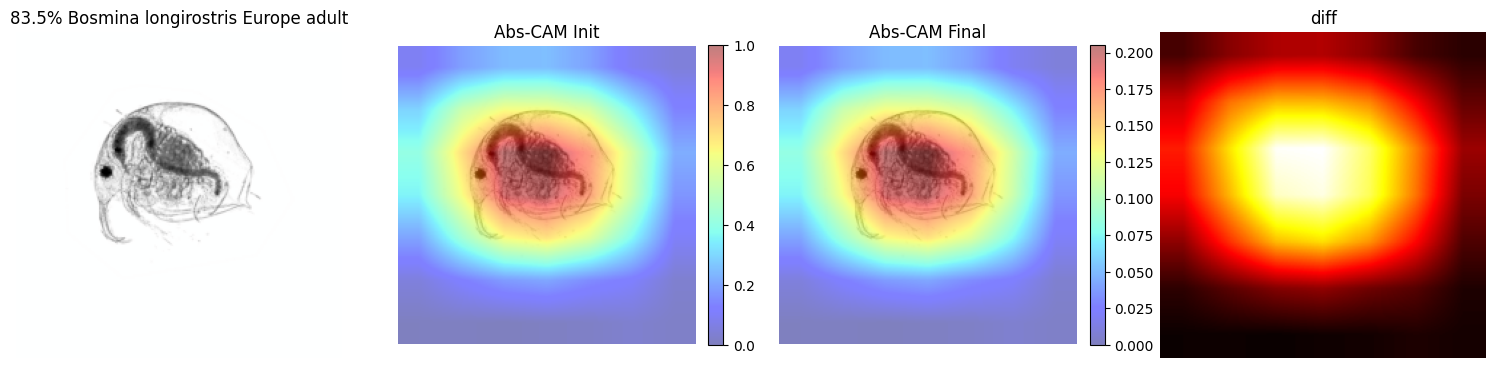

In [45]:
sample_img, label = val_dataset[6]
sample_img = sample_img.unsqueeze(0).to(device) 
explain_and_plot(sample_img, label=label, class_names=class_names)

saliency_init: 0.0 1.0 0.36463111639022827
saliency_final: 0.0 0.5755506753921509 0.20986367762088776


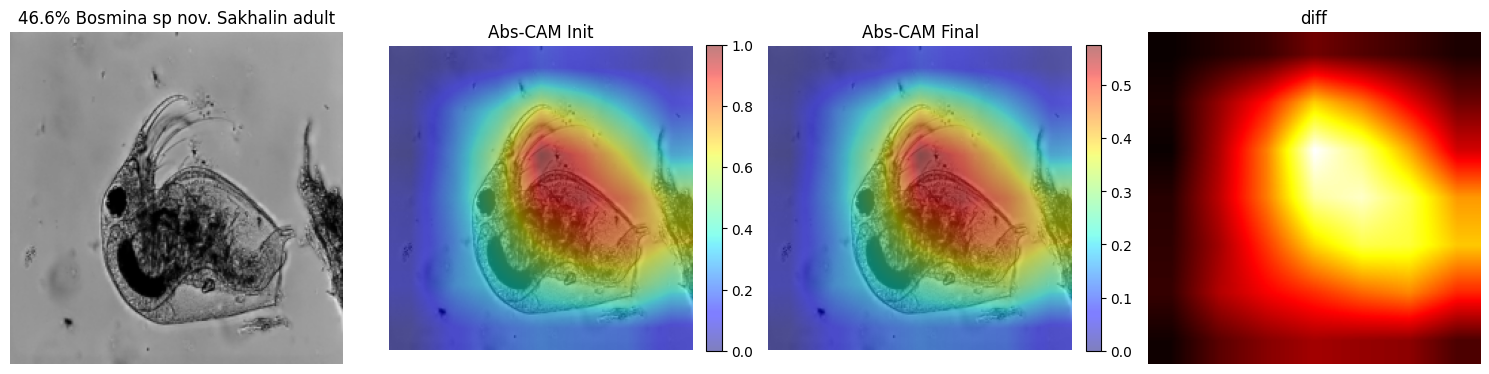

In [20]:
sample_img, label = val_dataset[4]
sample_img = sample_img.unsqueeze(0).to(device) 
explain_and_plot(sample_img, label=label, class_names=class_names)

saliency_init: 0.0 1.0 0.32942885160446167
saliency_final: 0.0 0.14571796357631683 0.048003699630498886


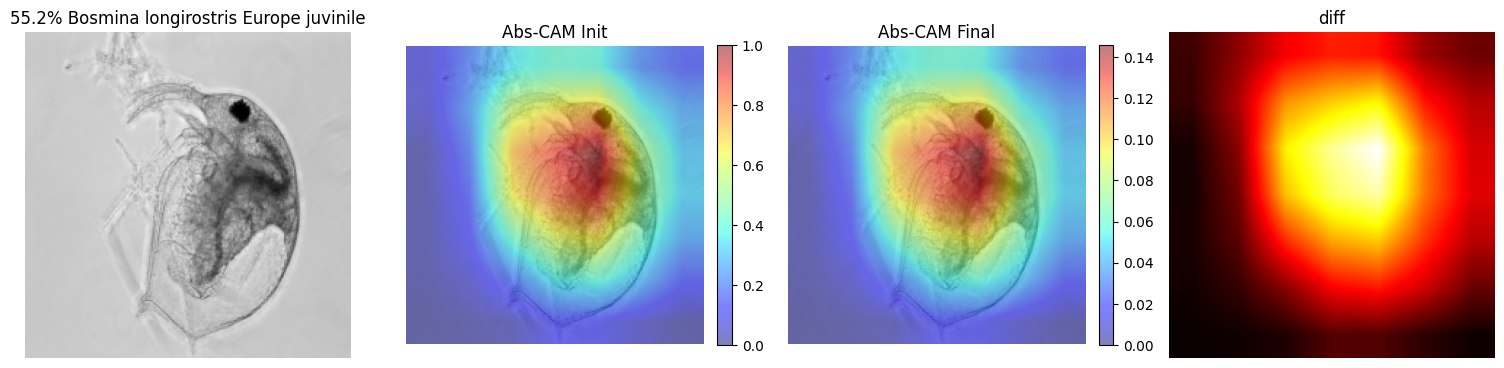

In [22]:
sample_img, label = val_dataset[8]
sample_img = sample_img.unsqueeze(0).to(device) 
explain_and_plot(sample_img, label=label, class_names=class_names)

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from abs_cam import AbsCAMInit 

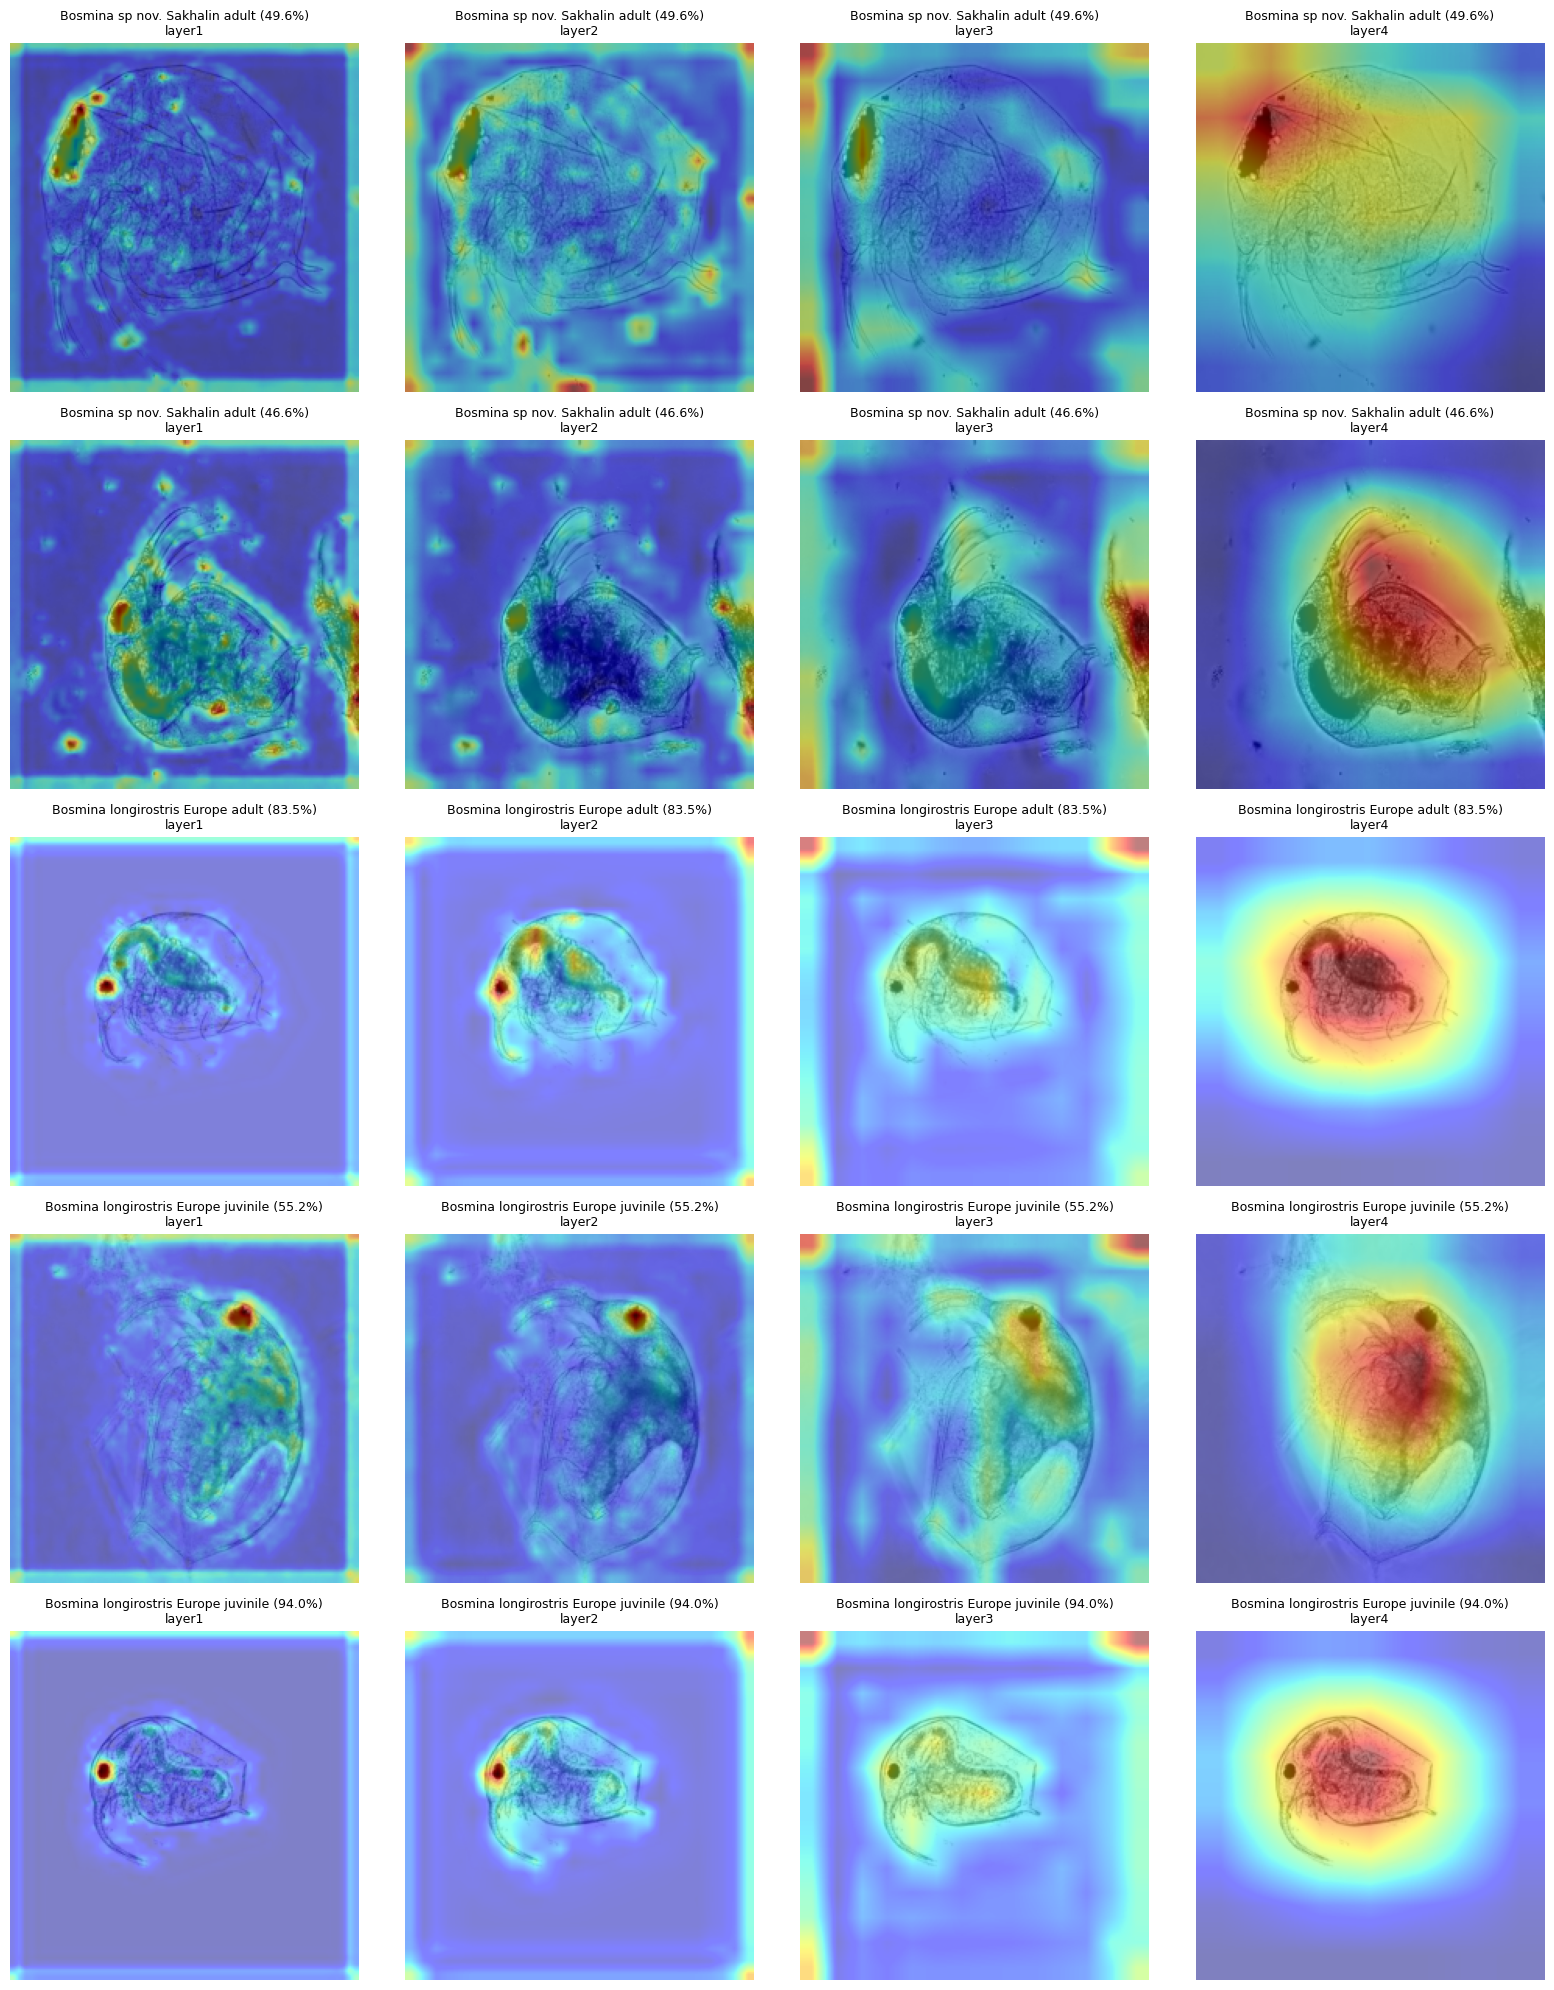

In [25]:
layers_to_check = ['layer1', 'layer2', 'layer3', 'layer4']
num_images = 5

# indices = random.sample(range(len(val_dataset)), num_images)
indices = [0, 4, 6, 8, 9]
images = [val_dataset[i][0].unsqueeze(0).to(device) for i in indices]

plt.figure(figsize=(len(layers_to_check) * 4, num_images * 4))

for row_idx, img in enumerate(images):
    with torch.no_grad():
        output = model(img)
        probs = torch.softmax(output, dim=1)
        conf, class_idx = torch.max(probs, dim=1)
        class_name = class_names[class_idx.item()]

    for col_idx, layer in enumerate(layers_to_check):
        explainer = AbsCAMInit(model, target_layer=layer, device=device)
        saliency = explainer(img).astype(np.float32)

        plt_idx = row_idx * len(layers_to_check) + col_idx + 1
        plt.subplot(num_images, len(layers_to_check), plt_idx)
        plt.axis('off')
        plt.title(f"{class_name} ({conf.item()*100:.1f}%)\n{layer}", fontsize=9)
        tensor_imshow(img[0].cpu())
        plt.imshow(saliency, cmap='jet', alpha=0.5)

plt.tight_layout()
plt.show()

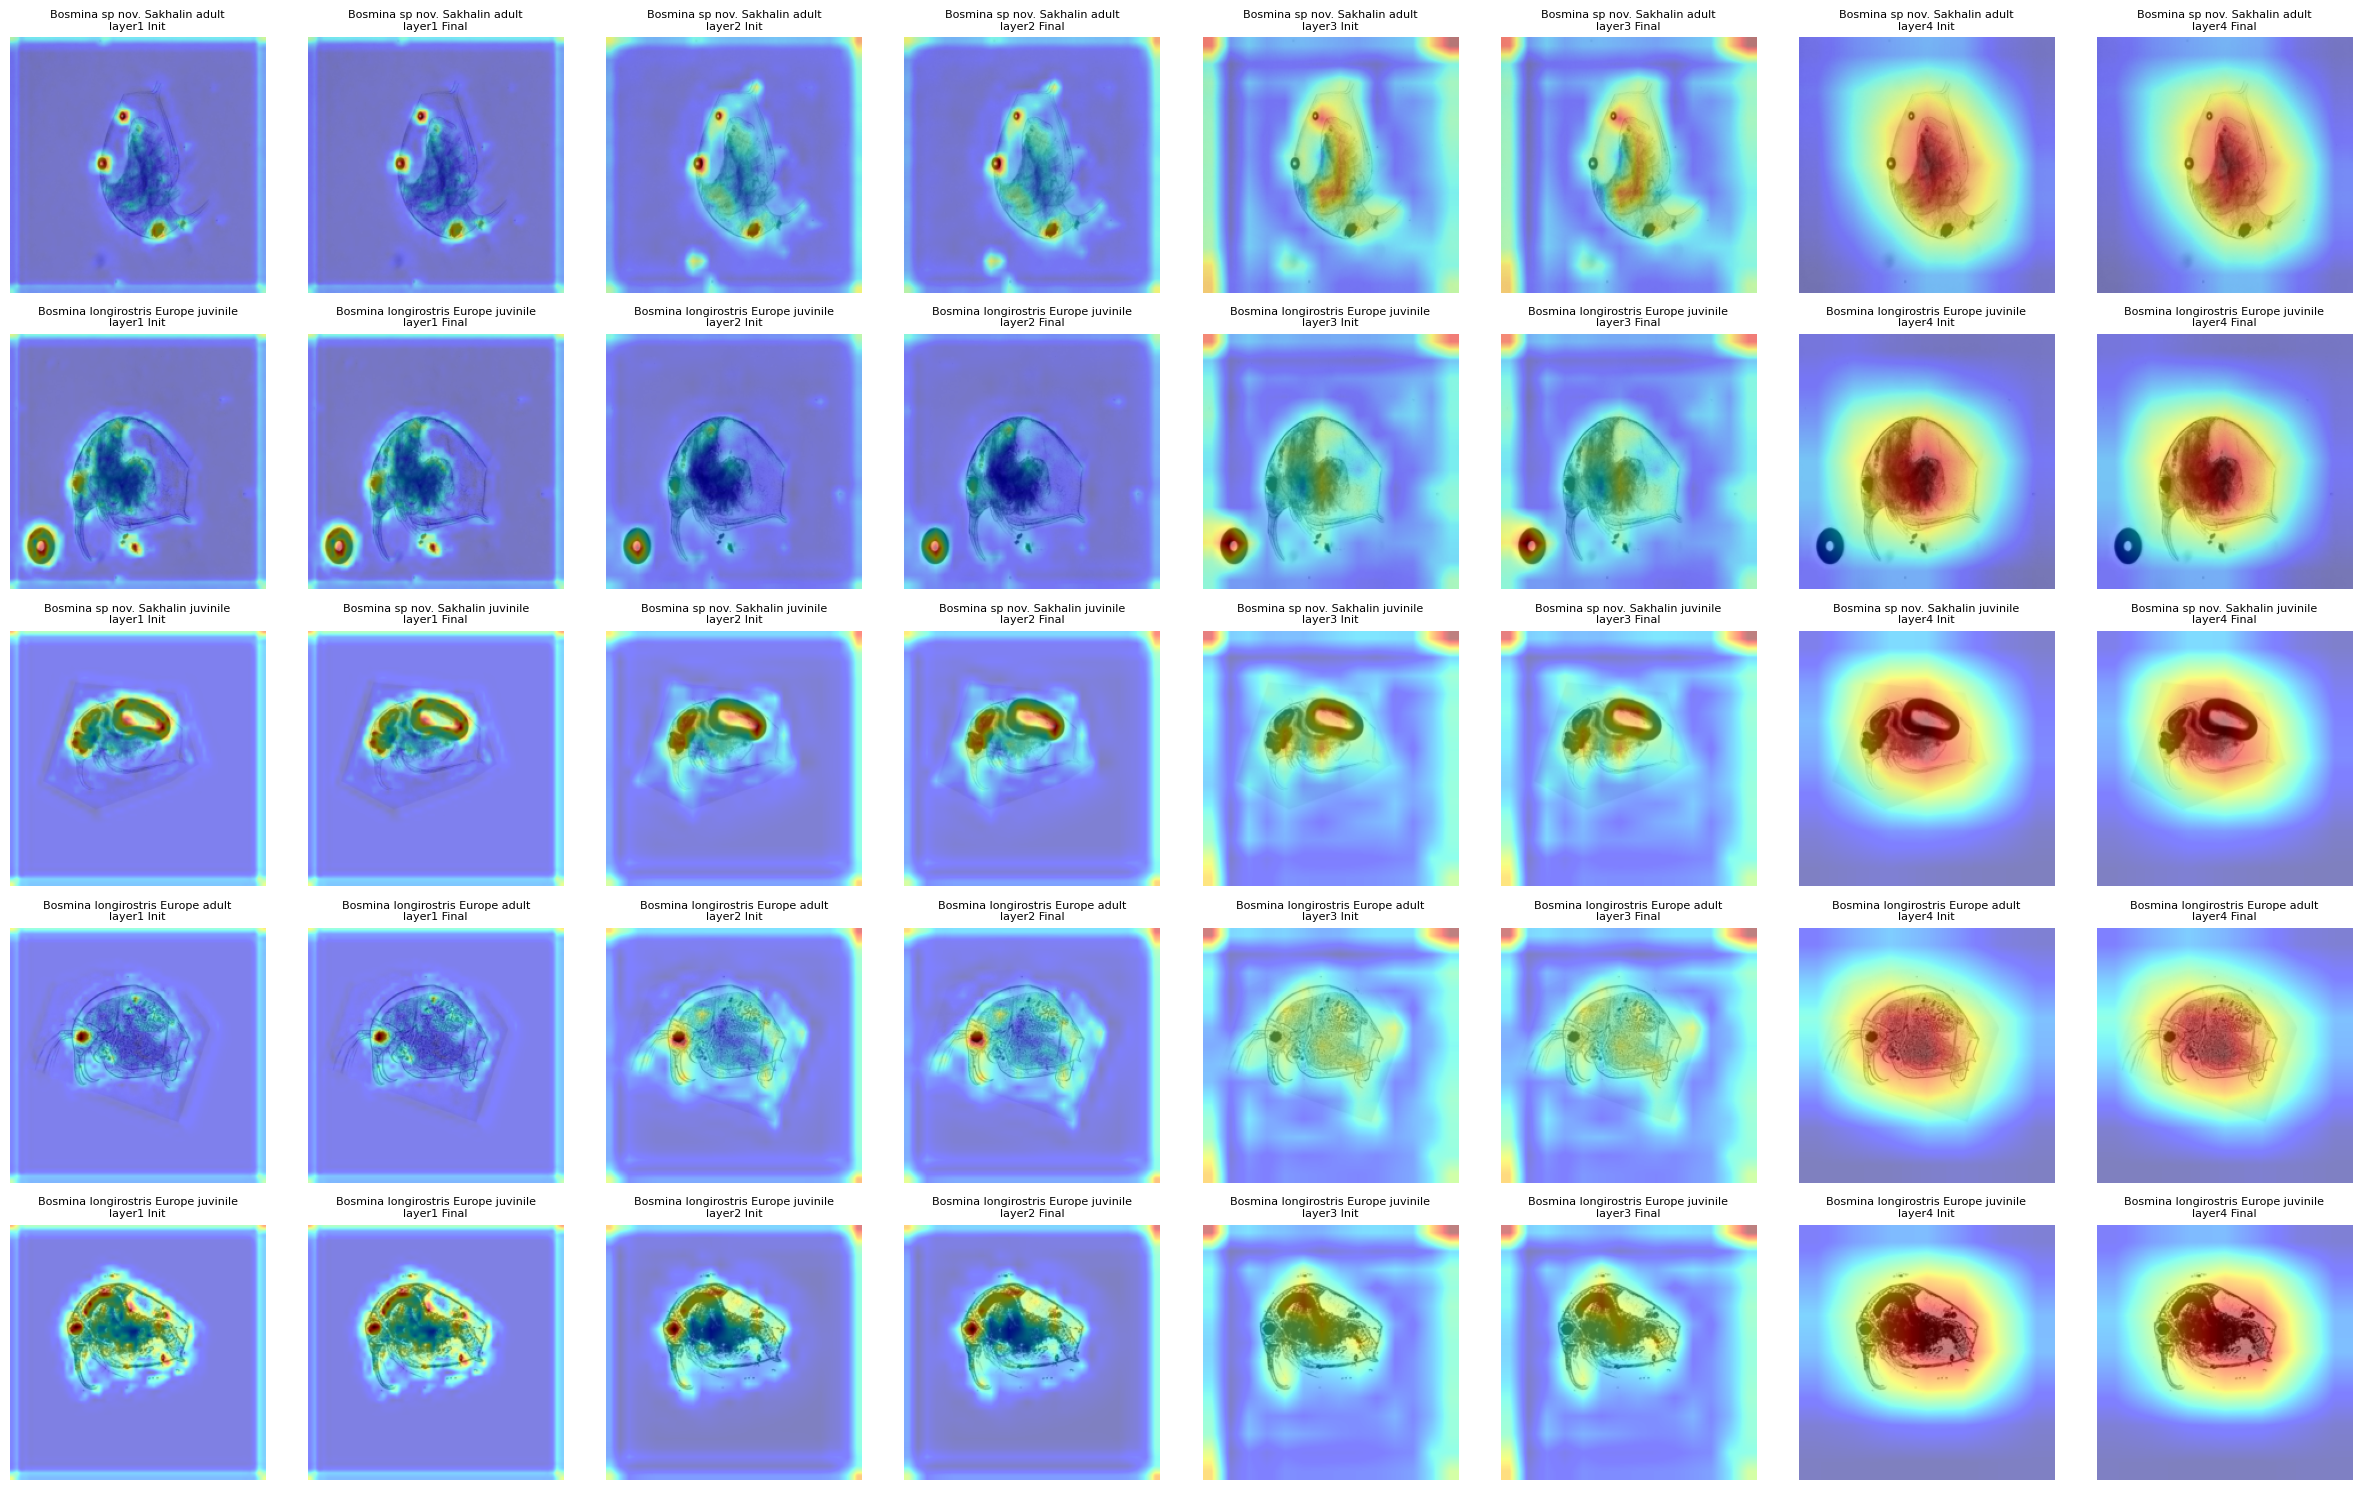

In [26]:
layers_to_check = ['layer1', 'layer2', 'layer3', 'layer4']
num_images = 5

indices = random.sample(range(len(val_dataset)), num_images)
images = [val_dataset[i][0].unsqueeze(0).to(device) for i in indices]

plt.figure(figsize=(len(layers_to_check) * 2 * 3, num_images * 3))

for row_idx, img in enumerate(images):
    with torch.no_grad():
        output = model(img)
        probs = torch.softmax(output, dim=1)
        conf, class_idx = torch.max(probs, dim=1)
        class_name = class_names[class_idx.item()]

    for col_idx, layer in enumerate(layers_to_check):
        explainer_init = AbsCAMInit(model, target_layer=layer, device=device)
        explainer_final = AbsCAMFinal(model, target_layer=layer, device=device)

        saliency_init = explainer_init(img).astype(np.float32)
        saliency_final = explainer_final(img).astype(np.float32)

        # Init map
        idx_init = row_idx * len(layers_to_check) * 2 + col_idx * 2 + 1
        plt.subplot(num_images, len(layers_to_check) * 2, idx_init)
        plt.axis('off')
        plt.title(f"{class_name}\n{layer} Init", fontsize=8)
        tensor_imshow(img[0].cpu())
        plt.imshow(saliency_init, cmap='jet', alpha=0.5)

        # Final map
        idx_final = row_idx * len(layers_to_check) * 2 + col_idx * 2 + 2
        plt.subplot(num_images, len(layers_to_check) * 2, idx_final)
        plt.axis('off')
        plt.title(f"{class_name}\n{layer} Final", fontsize=8)
        tensor_imshow(img[0].cpu())
        plt.imshow(saliency_final, cmap='jet', alpha=0.5)

plt.tight_layout()
plt.show()


In [27]:
klen = 11
ksig = 5
kern = gkern(klen, ksig)

# Function that blurs input image
blur = lambda x: nn.functional.conv2d(x, kern.to(x.device), padding=klen//2)

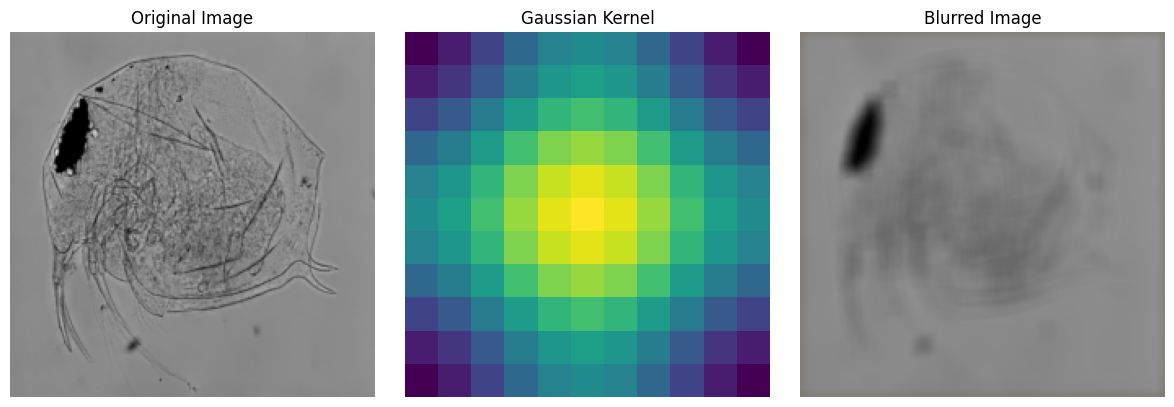

In [28]:
def plot_blur(img):
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.axis('off')
    plt.title("Original Image")
    tensor_imshow(img[0])

    plt.subplot(132)
    plt.axis('off')
    plt.title("Gaussian Kernel")
    plt.imshow(kern[0, 0])

    plt.subplot(133)
    plt.axis('off')
    plt.title("Blurred Image")
    tensor_imshow(blur(img)[0])

    plt.tight_layout()
    plt.show()

sample_img, label = val_dataset[0]
sample_img = sample_img.unsqueeze(0).to(device)
plot_blur(sample_img)

In [29]:
insertion = CausalMetric(model, 'ins', 224, substrate_fn=blur)
deletion = CausalMetric(model, 'del', 224, substrate_fn=torch.zeros_like)

In [30]:
sample_img, label = val_dataset[4]
sample_img = sample_img.unsqueeze(0).to(device)
saliency = explainer(sample_img).astype(np.float32)

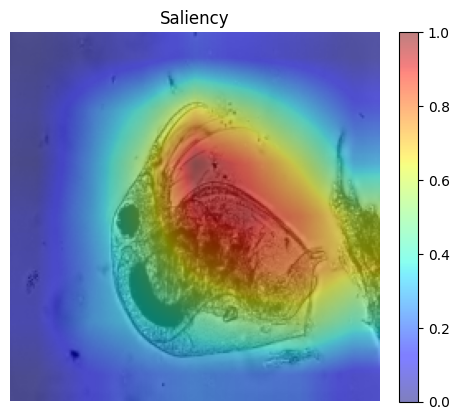

In [31]:
plt.axis('off')
plt.title('Saliency')
tensor_imshow(sample_img[0])
plt.imshow(saliency, cmap='jet', alpha=0.5)
plt.colorbar(fraction=0.046, pad=0.04)

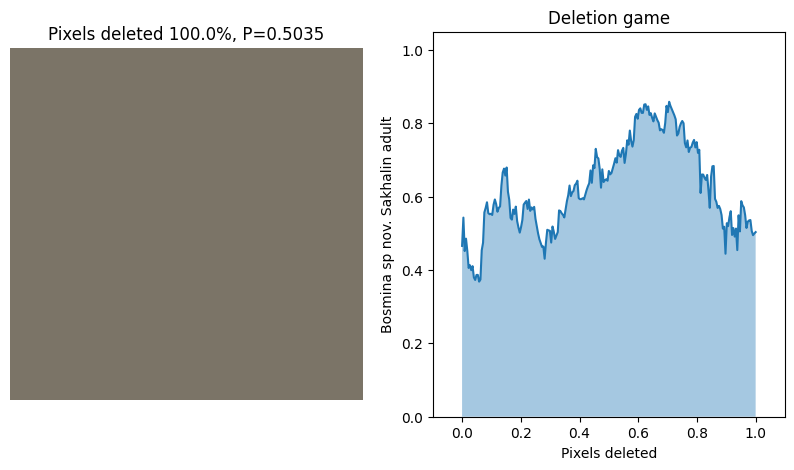

In [32]:
h = deletion.single_run(sample_img, saliency, class_names=class_names, device=device, verbose=1, mode='abs_cam')

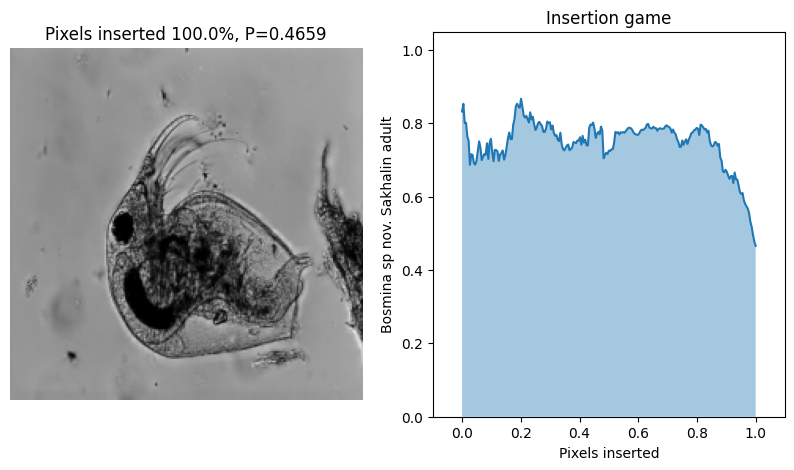

In [33]:
h = insertion.single_run(sample_img, saliency, class_names=class_names, device=device, verbose=1, mode='abs_cam')

In [34]:
images = []
explanations = []

for i in range(len(val_dataset)):
    img, _ = val_dataset[i]
    img = img.unsqueeze(0).to(device)
    saliency = explainer(img).astype(np.float32)
    saliency = explainer(img).astype(np.float32)
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)
    
    images.append(img.squeeze(0).cpu())
    explanations.append(saliency)

images_tensor = torch.stack(images).to(device)
saliency_np = np.stack(explanations)

insertion = CausalMetric(model, 'ins', step=224*8, substrate_fn=blur)
deletion = CausalMetric(model, 'del', step=224*8, substrate_fn=torch.zeros_like)

h_del = deletion.evaluate(images_tensor, saliency_np, device=device, batch_size=1, mode='abs_cam')
h_ins = insertion.evaluate(images_tensor, saliency_np, device=device, batch_size=1, mode='abs_cam')

print('Deletion AUC:', auc(h_del.mean(1)))
print('Insertion AUC:', auc(h_ins.mean(1)))


Deleting  pixels: 100%|██████████| 29/29 [00:11<00:00,  2.47it/s]


AUC: 0.33314667018079885


Inserting pixels: 100%|██████████| 29/29 [00:11<00:00,  2.43it/s]

AUC: 0.6425485342186003
Deletion AUC: 0.33314667018079885
Insertion AUC: 0.6425485342186003


In [35]:
layers = ['layer1', 'layer2', 'layer3', 'layer4']
results = {}

for layer in layers:
    print(f"\nEvaluating for layer: {layer}")
    explainer = AbsCAMInit(model, target_layer=layer, device=device)
    
    images = []
    explanations = []

    for i in range(len(val_dataset)):
        img, _ = val_dataset[i]
        img = img.unsqueeze(0).to(device)

        saliency = explainer(img).astype(np.float32)
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)

        images.append(img.squeeze(0).cpu())
        explanations.append(saliency)

    images_tensor = torch.stack(images).to(device)
    saliency_np = np.stack(explanations)

    insertion = CausalMetric(model, 'ins', step=224*8, substrate_fn=blur)
    deletion = CausalMetric(model, 'del', step=224*8, substrate_fn=torch.zeros_like)

    h_del = deletion.evaluate(images_tensor, saliency_np, device=device, batch_size=1, mode='abs_cam')
    h_ins = insertion.evaluate(images_tensor, saliency_np, device=device, batch_size=1, mode='abs_cam')

    deletion_auc = auc(h_del.mean(1))
    insertion_auc = auc(h_ins.mean(1))

    print(f"Layer {layer} — Deletion AUC: {deletion_auc:.4f}, Insertion AUC: {insertion_auc:.4f}")
    results[layer] = {'deletion_auc': deletion_auc, 'insertion_auc': insertion_auc}


Evaluating for layer: layer1


Deleting  pixels: 100%|██████████| 29/29 [00:11<00:00,  2.48it/s]


AUC: 0.3370493288782585


Inserting pixels: 100%|██████████| 29/29 [00:12<00:00,  2.36it/s]


AUC: 0.6649689969531043
Layer layer1 — Deletion AUC: 0.3370, Insertion AUC: 0.6650

Evaluating for layer: layer2


Deleting  pixels: 100%|██████████| 29/29 [00:12<00:00,  2.36it/s]


AUC: 0.32453896616367395


Inserting pixels: 100%|██████████| 29/29 [00:11<00:00,  2.42it/s]


AUC: 0.6630392980061377
Layer layer2 — Deletion AUC: 0.3245, Insertion AUC: 0.6630

Evaluating for layer: layer3


Deleting  pixels: 100%|██████████| 29/29 [00:11<00:00,  2.45it/s]


AUC: 0.29823191103442964


Inserting pixels: 100%|██████████| 29/29 [00:11<00:00,  2.43it/s]


AUC: 0.6285680748942288
Layer layer3 — Deletion AUC: 0.2982, Insertion AUC: 0.6286

Evaluating for layer: layer4


Deleting  pixels: 100%|██████████| 29/29 [00:11<00:00,  2.44it/s]


AUC: 0.33314667018079885


Inserting pixels: 100%|██████████| 29/29 [00:11<00:00,  2.45it/s]

AUC: 0.6425485342186003
Layer layer4 — Deletion AUC: 0.3331, Insertion AUC: 0.6425


In [36]:
for layer in layers:
    print(f"Layer {layer} — Deletion AUC: {results[layer]['deletion_auc']:.4f}, Insertion AUC: {results[layer]['insertion_auc']:.4f}")

Layer layer1 — Deletion AUC: 0.3370, Insertion AUC: 0.6650
Layer layer2 — Deletion AUC: 0.3245, Insertion AUC: 0.6630
Layer layer3 — Deletion AUC: 0.2982, Insertion AUC: 0.6286
Layer layer4 — Deletion AUC: 0.3331, Insertion AUC: 0.6425


In [37]:
layers = ['layer1', 'layer2', 'layer3', 'layer4']
results = {}

for layer in layers:
    print(f"\nEvaluating for layer: {layer}")

    # --- AbsCAMInit ---
    explainer_init = AbsCAMInit(model, target_layer=layer, device=device)
    
    images = []
    explanations_init = []

    for i in range(len(val_dataset)):
        img, _ = val_dataset[i]
        img = img.unsqueeze(0).to(device)

        saliency = explainer_init(img).astype(np.float32)
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)

        images.append(img.squeeze(0).cpu())
        explanations_init.append(saliency)

    images_tensor = torch.stack(images).to(device)
    saliency_np_init = np.stack(explanations_init)

    insertion = CausalMetric(model, 'ins', step=224*8, substrate_fn=blur)
    deletion = CausalMetric(model, 'del', step=224*8, substrate_fn=torch.zeros_like)

    h_del_init = deletion.evaluate(images_tensor, saliency_np_init, device=device, batch_size=1, mode='abs_cam')
    h_ins_init = insertion.evaluate(images_tensor, saliency_np_init, device=device, batch_size=1, mode='abs_cam')

    deletion_auc_init = auc(h_del_init.mean(1))
    insertion_auc_init = auc(h_ins_init.mean(1))

    print(f"AbsCAMInit @ {layer} — Deletion AUC: {deletion_auc_init:.4f}, Insertion AUC: {insertion_auc_init:.4f}")
    
    # --- AbsCAMFinal ---
    explainer_final = AbsCAMFinal(model, target_layer=layer, device=device)
    explanations_final = []

    for i in range(len(val_dataset)):
        img, _ = val_dataset[i]
        img = img.unsqueeze(0).to(device)

        saliency = explainer_final(img).astype(np.float32)
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)

        explanations_final.append(saliency)

    saliency_np_final = np.stack(explanations_final)

    h_del_final = deletion.evaluate(images_tensor, saliency_np_final, device=device, batch_size=1, mode='abs_cam')
    h_ins_final = insertion.evaluate(images_tensor, saliency_np_final, device=device, batch_size=1, mode='abs_cam')

    deletion_auc_final = auc(h_del_final.mean(1))
    insertion_auc_final = auc(h_ins_final.mean(1))

    print(f"AbsCAMFinal @ {layer} — Deletion AUC: {deletion_auc_final:.4f}, Insertion AUC: {insertion_auc_final:.4f}")

    # Save both results
    results[layer] = {
        'init': {'deletion_auc': deletion_auc_init, 'insertion_auc': insertion_auc_init},
        'final': {'deletion_auc': deletion_auc_final, 'insertion_auc': insertion_auc_final}
    }

# --- Print Summary ---
for layer in layers:
    print(f"\nLayer {layer}:")
    print(f"  AbsCAMInit  — Deletion AUC: {results[layer]['init']['deletion_auc']:.4f}, Insertion AUC: {results[layer]['init']['insertion_auc']:.4f}")
    print(f"  AbsCAMFinal — Deletion AUC: {results[layer]['final']['deletion_auc']:.4f}, Insertion AUC: {results[layer]['final']['insertion_auc']:.4f}")



Evaluating for layer: layer1


Deleting  pixels: 100%|██████████| 29/29 [00:12<00:00,  2.39it/s]


AUC: 0.3370493288782585


Inserting pixels: 100%|██████████| 29/29 [00:12<00:00,  2.38it/s]


AUC: 0.6649689969531043
AbsCAMInit @ layer1 — Deletion AUC: 0.3370, Insertion AUC: 0.6650


Deleting  pixels: 100%|██████████| 29/29 [00:11<00:00,  2.45it/s]


AUC: 0.3370493288782585


Inserting pixels: 100%|██████████| 29/29 [00:11<00:00,  2.44it/s]


AUC: 0.6649689969531043
AbsCAMFinal @ layer1 — Deletion AUC: 0.3370, Insertion AUC: 0.6650

Evaluating for layer: layer2


Deleting  pixels: 100%|██████████| 29/29 [00:11<00:00,  2.44it/s]


AUC: 0.32453896616367395


Inserting pixels: 100%|██████████| 29/29 [00:11<00:00,  2.43it/s]


AUC: 0.6630392980061377
AbsCAMInit @ layer2 — Deletion AUC: 0.3245, Insertion AUC: 0.6630


Deleting  pixels: 100%|██████████| 29/29 [00:11<00:00,  2.43it/s]


AUC: 0.32453896616367395


Inserting pixels: 100%|██████████| 29/29 [00:11<00:00,  2.45it/s]


AUC: 0.6630392980061377
AbsCAMFinal @ layer2 — Deletion AUC: 0.3245, Insertion AUC: 0.6630

Evaluating for layer: layer3


Deleting  pixels: 100%|██████████| 29/29 [00:12<00:00,  2.33it/s]


AUC: 0.29823191103442964


Inserting pixels: 100%|██████████| 29/29 [00:12<00:00,  2.39it/s]


AUC: 0.6285680748942288
AbsCAMInit @ layer3 — Deletion AUC: 0.2982, Insertion AUC: 0.6286


Deleting  pixels: 100%|██████████| 29/29 [00:11<00:00,  2.46it/s]


AUC: 0.29823191103442964


Inserting pixels: 100%|██████████| 29/29 [00:12<00:00,  2.41it/s]


AUC: 0.6285680748942288
AbsCAMFinal @ layer3 — Deletion AUC: 0.2982, Insertion AUC: 0.6286

Evaluating for layer: layer4


Deleting  pixels: 100%|██████████| 29/29 [00:11<00:00,  2.43it/s]


AUC: 0.33314667018079885


Inserting pixels: 100%|██████████| 29/29 [00:11<00:00,  2.49it/s]


AUC: 0.6425485342186003
AbsCAMInit @ layer4 — Deletion AUC: 0.3331, Insertion AUC: 0.6425


Deleting  pixels: 100%|██████████| 29/29 [00:11<00:00,  2.43it/s]


AUC: 0.33314688139536724


Inserting pixels: 100%|██████████| 29/29 [00:11<00:00,  2.43it/s]

AUC: 0.6425487659587877
AbsCAMFinal @ layer4 — Deletion AUC: 0.3331, Insertion AUC: 0.6425

Layer layer1:
  AbsCAMInit  — Deletion AUC: 0.3370, Insertion AUC: 0.6650
  AbsCAMFinal — Deletion AUC: 0.3370, Insertion AUC: 0.6650

Layer layer2:
  AbsCAMInit  — Deletion AUC: 0.3245, Insertion AUC: 0.6630
  AbsCAMFinal — Deletion AUC: 0.3245, Insertion AUC: 0.6630

Layer layer3:
  AbsCAMInit  — Deletion AUC: 0.2982, Insertion AUC: 0.6286
  AbsCAMFinal — Deletion AUC: 0.2982, Insertion AUC: 0.6286

Layer layer4:
  AbsCAMInit  — Deletion AUC: 0.3331, Insertion AUC: 0.6425
  AbsCAMFinal — Deletion AUC: 0.3331, Insertion AUC: 0.6425
